In [22]:
import pandas as pd
import numpy as np

In [23]:
df = pd.read_csv('preprocessed_dataset_full.csv')

In [24]:
df

,prompt,completion
0,writing inform job may threat organization con...,2
1,still unsure department losing staff many need...,2
2,want meet discus,12
3,regrettable role one post threat,2
4,need move forward,2
...,...,...
3422,rely achieve goal part commitment lie efficien...,6
3423,paper ifus previously included packaging proce...,3
3424,big undertaking short space time built laptop ...,9
3425,one really needed paper manual everything,9


In [25]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['completion'])

In [26]:
data_train.shape, data_test.shape

((3084, 2), (343, 2))

In [27]:
print(len(data_train['completion'].value_counts())), print(len(data_test['completion'].value_counts()))

30
30


(None, None)

In [28]:
from tensorflow.keras.utils import to_categorical

In [29]:
y_train = to_categorical(data_train.completion)
y_test = to_categorical(data_test.completion)

In [30]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
!pip install transformers
import transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
from transformers import AutoTokenizer,TFBertModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [33]:
x_train = tokenizer (
    text = data_train.prompt.tolist(),
    add_special_tokens = True,
    max_length = 64,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_test = tokenizer (
    text = data_test.prompt.tolist(),
    add_special_tokens = True,
    max_length = 64,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

In [34]:
x_train

{'input_ids': <tf.Tensor: shape=(3084, 64), dtype=int32, numpy=
array([[ 101, 1271, 1156, ...,    0,    0,    0],
       [ 101, 3232, 1383, ...,    0,    0,    0],
       [ 101, 1419, 2356, ...,    0,    0,    0],
       ...,
       [ 101, 2463, 4517, ...,    0,    0,    0],
       [ 101, 1884, 4661, ...,    0,    0,    0],
       [ 101, 7775, 2816, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3084, 64), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [35]:
x_test

{'input_ids': <tf.Tensor: shape=(343, 64), dtype=int32, numpy=
array([[  101,  4725,  1965, ...,     0,     0,     0],
       [  101,  2393,  7235, ...,     0,     0,     0],
       [  101,  1546,  3531, ...,     0,     0,     0],
       ...,
       [  101,   177,  2217, ...,     0,     0,     0],
       [  101, 23290, 18349, ...,     0,     0,     0],
       [  101,  1560, 16416, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(343, 64), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [36]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

In [37]:
max_length = 64

from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_length,), dtype=tf.int32, name ='input_ids')
input_mask = Input(shape=(max_length,), dtype=tf.int32, name ='attention_mask')

embeddings = model(input_ids,attention_mask = input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(64, activation = 'relu')(out)

y = Dense(30, activation = 'sigmoid')(out) #30 sentiments

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [38]:
model.layers

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                            

In [40]:
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    clipnorm=1.0
)

loss =CategoricalCrossentropy()
metric = CategoricalAccuracy('accuracy'),

model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics= metric
)

In [41]:
train = model.fit(
    x = {'input_ids': x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
    y = y_train,
    validation_data = ({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test),
    epochs = 15,
    batch_size = 36
)

Epoch 1/15
86/86 [==============================] - 621s 7s/step - loss: 3.2621 - accuracy: 0.1044 - val_loss: 3.1601 - val_accuracy: 0.1399
Epoch 2/15
86/86 [==============================] - 632s 7s/step - loss: 3.1106 - accuracy: 0.1365 - val_loss: 3.1258 - val_accuracy: 0.1195
Epoch 3/15
86/86 [==============================] - 619s 7s/step - loss: 2.9902 - accuracy: 0.1654 - val_loss: 3.1224 - val_accuracy: 0.1312
Epoch 4/15
86/86 [==============================] - 582s 7s/step - loss: 2.8173 - accuracy: 0.2033 - val_loss: 3.1383 - val_accuracy: 0.1108
Epoch 5/15
86/86 [==============================] - 584s 7s/step - loss: 2.6165 - accuracy: 0.2464 - val_loss: 3.2533 - val_accuracy: 0.1079
Epoch 6/15
86/86 [==============================] - 584s 7s/step - loss: 2.4359 - accuracy: 0.2899 - val_loss: 3.2578 - val_accuracy: 0.1137
Epoch 7/15
86/86 [==============================] - 582s 7s/step - loss: 2.2386 - accuracy: 0.3346 - val_loss: 3.5128 - val_accuracy: 0.1108
Epoch 8/15
86

In [48]:
model.evaluate({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test)

11/11 [==============================] - 17s 2s/step - loss: 4.5189 - accuracy: 0.0612


[4.518918514251709, 0.06122449040412903]

In [42]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

11/11 [==============================] - 20s 2s/step


array([0.656884  , 0.10363031, 0.259188  , 0.7253719 , 0.10720455,
       0.9263395 , 0.14916213, 0.36661822, 0.8478236 , 0.9429128 ,
       0.9789175 , 0.23548219, 0.03961743, 0.3107304 , 0.20336056,
       0.9163917 , 0.42418185, 0.20472069, 0.99262685, 0.71728975,
       0.71015215, 0.03672089, 0.24941668, 0.3921196 , 0.39976424,
       0.4642519 , 0.9407304 , 0.7090409 , 0.10434556, 0.6670472 ],
      dtype=float32)

In [44]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = data_test.completion

In [45]:
print(y_true)

42       9
2862    26
1962     9
2700    14
3100     2
        ..
610     12
1185     0
647     15
1165     3
3058    15
Name: completion, Length: 343, dtype: int64


In [46]:
print(y_predicted)

[18 16  2  7  5 18  5 21 28 19  0 15 18 15 16 12 28  9  5  7 27  0 15 16
  3 10 15 24  9 18  2 14 27  9  1 27  2 22 12  7 18 10  1 10 10 14 15  9
 18 11 18  2 10  5 15  0  3 14 27  9  3 15 26 18  0 27 20 29  8 26  9  9
 18 26 10  3 18 10  2  0 11 24 16  3 15 10 27 16 27 14  3 16  9  5  3 27
  2 18  2 24  9  9  2 14 15  5  9 18 12 27 10 11 29 18 18  0 10 17  9  7
  3  3 29  7 10 16  5  1 19  1  7  9  3 10 18  9  9 20  3 18  7  9  7 14
  5 20 10 27 29 10 28 23 10  1  5 21 15  0 10 12 10 21 24 27 10  9 12  1
 12 27 18  2 20  7  9 18  2 27  8  5  8  8 10 27  5 23 20 29 22 12  9  5
 10 10 27 29  2 23 10  3 14 10 10 12  7 14  9  7  5 27 29 14 12 12  8 15
 18 28 15  7  1  9 14 12  3 26  9 18 22  2 18 18 26  2 24  9 14 24 18 13
 21  9 12 12  1  7 10 27  8  3 12 10  9  3 10  3  6  1 22  9 20  2 18 18
  3  5  3 27  0 15 15 24 22 28 10 29 18 18 12 17  9  7  2 10 18 15 27 10
  9 18 20  8  5 15  9 15 15 14 12 15 18 15 10  6 18 18 18  9 14 26  2 16
 10 14  2  9  7  5 25 29 23 10  6  2 24 27 10 18 16

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.11      0.17      0.13         6
           2       0.10      0.13      0.11        15
           3       0.11      0.13      0.12        15
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         9
           9       0.06      0.09      0.07        23
          10       0.17      0.13      0.14        47
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        20
          13       0.00      0.00      0.00         2
          14       0.07      0.07      0.07        15
          15       0.15      0.12      0.14        24
          16       0.00      0.00      0.00         7
          17       0.00    

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(95.72222222222221, 0.5, 'Truth')

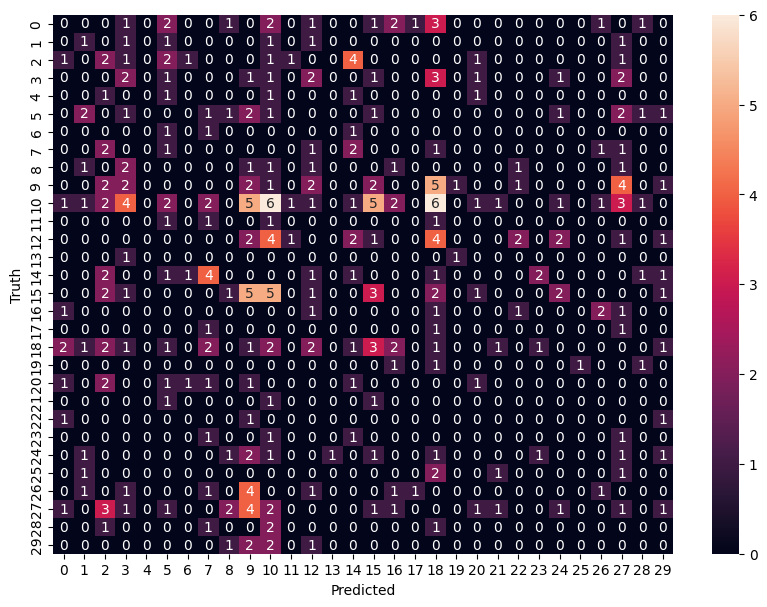

In [50]:
import seaborn as sn
from matplotlib import pyplot as plt
%matplotlib inline

cm = tf.math.confusion_matrix(labels=y_true,predictions=y_predicted)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [51]:
df_predictions = pd.DataFrame({'y_true': y_true, 'y_predicted': y_predicted})
print(df_predictions)

      y_true  y_predicted
42         9           18
2862      26           16
1962       9            2
2700      14            7
3100       2            5
...      ...          ...
610       12           10
1185       0            5
647       15            9
1165       3           27
3058      15            9

[343 rows x 2 columns]


In [53]:
correct_predictions = (df_predictions['y_true'] == df_predictions['y_predicted']).sum()
print(correct_predictions)

21


In [54]:
df_predictions.shape

(343, 2)

In [55]:
df_predictions['y_predicted'].value_counts()

y_predicted
10    36
18    34
9     33
27    22
2     21
15    20
3     19
5     17
7     16
12    16
14    15
16    10
29     9
1      9
24     8
0      8
20     7
8      7
26     6
28     5
22     5
21     4
23     4
11     3
6      3
19     2
17     2
13     1
25     1
Name: count, dtype: int64

In [1]:
df_predictions

NameError: name 'df_predictions' is not defined

In [56]:
10    466
18    239
15    236
9     230
27    205
12    201
0     161
3     154
14    147
2     147
5     143
26    114
24    111
7      93
20     88
8      85
16     74
1      63
29     57
4      49
28     49
25     47
19     43
11     42
23     42
21     34
22     32
17     32
6      28
13     15

SyntaxError: invalid syntax (3846877110.py, line 1)

In [66]:
optimizer2 = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    weight_decay=0.01
)

loss =CategoricalCrossentropy()
metric = CategoricalAccuracy('balanced_accuracy'),

model.compile(
    optimizer = optimizer2,
    loss = loss, 
    metrics= metric
)

In [67]:
train2 = model.fit(
    x = {'input_ids': x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
    y = y_train,
    validation_data = ({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test),
    epochs = 1,
    batch_size = 36
)

86/86 [==============================] - 605s 7s/step - loss: 1.2171 - balanced_accuracy: 0.5470 - val_loss: 4.8719 - val_balanced_accuracy: 0.0641


In [65]:
model.evaluate({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test)

11/11 [==============================] - 18s 2s/step - loss: 4.7083 - balanced_accuracy: 0.0466


[4.708252429962158, 0.04664723202586174]